In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn_pandas import DataFrameMapper

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics

from sklearn.model_selection import GridSearchCV


# Assignement 2 - Lending Club
## Isaac Schaal

### 1. Getting and Importing the data

I chose the most recent data from the Lending Club Website. This was Q2 2018. This way, my predictive model would be as relevant as possible for future predictions, if it were to be applied in the real world.

In [2]:
#the last two rows are empty
approved = pd.read_csv("LoanStats_2018Q2.csv", header=1, skipfooter=2, engine = 'python') 
approved.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,10000,10000,10000,36 months,20.39%,373.63,D,D4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,20000,20000,20000,60 months,13.06%,455.68,C,C1,...,NaN,NaN,DirectPay,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,14000,14000,14000,60 months,10.56%,301.34,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,8000,8000,8000,36 months,6.83%,246.40,A,A3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,22000,22000,22000,60 months,17.47%,552.34,D,D1,...,NaN,NaN,DirectPay,N,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
rejected = pd.read_csv("RejectStats_2018Q2.csv", header=1, engine = 'python')
rejected.head()

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,10000.0,2018-04-01,Debt consolidation,NaN,35.76%,167xx,PA,< 1 year,0
1,6000.0,2018-04-01,Credit card refinancing,NaN,13.19%,553xx,MN,6 years,2
2,3000.0,2018-04-01,Home improvement,NaN,100%,351xx,TN,< 1 year,0
3,4000.0,2018-04-01,Car financing,NaN,1.93%,601xx,IL,< 1 year,0
4,2000.0,2018-04-01,Other,NaN,14.96%,894xx,NV,< 1 year,0


### 2. Selecting Features

The approved data set has 145 features, which was initally overwhelming. The rejected, however, only has 9. Thus, this narrowed down what we could use a lot. 

There are 9 features in the rejected column. At this stage, I chose 6 of them to use.

1. **Amount Requested** - This is the amount requested in the loan.
2. **Loan Title** - This is the purpose of the loan.
3. **Debt-To-Income Ratio** - This is the Debt-to-Income ratio, showing the ratio of a persons' debt to income. Thus, a higher ratio indicates more current debt compared to income, which is not a good sign when asking for a loan.
4. **Zip Code** - The zip code of the applicant, with the last two digits deleted. (This was eventually removed due to it creating too many features and overlapping with the State
5. **State** - The state where the applicant resides
6. **Employment Length** - How long the applicant has been employed. This ranges from <1 year to 10+ years, with some N/As

There were several features from the rejected data that I didn't include. Firstly, the application date. There was no equivalent in the accepted data, and the exact date of the loan application didn't seem relevant to if it was rejected. Secondly, the Risk_Score. This seemed like it would be a helpful feature, however, it was not included for several reasons. Firstly, there was no equivalent in the accepted data. I tried to find something in the accepted data that could be converted, but without success. The Risk Scores range from 500 to over 900, while tipical FICO credit scores range from 300 to 850, so I didn't want to attempt that approach. Secondly, there were a large amount (over half) of N/As in the data. There are several methods to approach this, but with the knowledge that there is no equivalent feature in the approved, it was simply dropped. Finally, I didn't include Policy Code. There was an equivalent Policy Code in the approved data. However, it was 1 for all approved and either 0 or 2 for all rejected. Thus, it is perfectly correlated with the loan being approved, and wouldn't be appropriate to include in a classifier.


I did a bit of pre-merge cleaning to make the data in rejected and approved match. This included changing the names of the columns, and deleting the % signs from the Debt to Income Ratio in the rejected data.

I then combined the datasets into one set.

In [4]:
# Choose the features that are counterparts of the rejected data features
cleaned_approved = approved.loc[:,[
'loan_amnt', 'title',  'dti','zip_code', 'addr_state', 'emp_length']]
cleaned_approved['approved'] = True


In [5]:
# Select the correct features
cleaned_rejected = rejected.loc[:, ['Amount Requested',
 'Loan Title',
 'Debt-To-Income Ratio',
 'Zip Code',
 'State',
 'Employment Length']]

In [6]:
# Change the column names to the new names
cleaned_rejected.columns = [
'loan_amnt', 'title',  'dti','zip_code', 'addr_state', 'emp_length']
cleaned_rejected['approved'] = False

# Delete the % in the dti
newstr_list = []
for string in cleaned_rejected.dti:
    newstr = string.replace("%", '')
    newstr_list.append(newstr)
cleaned_rejected['dti'] = newstr_list


In [7]:
# Combine the data
loan_data = pd.concat([cleaned_approved, cleaned_rejected]).reset_index(drop=True)

### 3. Cleaning

I then started to clean the data.

The first thing to do was to change some of the categories in the title column. The only categories that needed help were 'Business' and "Business Loan', where were merged into 'Business'

I then looked for N/As in the features.

The first was dti, which had 326 missing values. Through looking at the histograms of the data, it was clear that it was heavily skewed, and thus it was better to fill the N/As with the median (as opposed to the mean). There were also -1 values in the dti. Everyone who had -1 values for dti also had <1 year of employment, so I assumed that they were unable to calculate it due to lack of income. To fix this, during the rescaling stage I changed all -1's to the max of the rescaled data, in order to show that these data points have poor dti ratios (which is consistent with them not having income).

The second feature which needed help was the emplyment length. They previosuly were all strings, and I converted them to floats, setting 10+ to 10 and <1 year to 0.5. I then set all of the N/As (2.85%) to 0. This relies on the assumpution that anyone who is employed would include that in their application for a loan, and thus the N/As are probably not employed.

I also dropped the Zip Code feature. Upon examination, there were almost 1,000 unique zip codes. The only way to use these in a predictive model would be to onehot encode them, and this would create almost a thousand new dimensions, with almost all of data points being 0. This seemed like it wouldn't add much to the model, especially given that this data overlaps with the addr_state, as it is the location.

Finally, I converted the title and addr_state columns to categorical data.

In [8]:
# Look at the titles
np.unique(loan_data.title)

array(['Business', 'Business Loan', 'Car financing',
       'Credit card refinancing', 'Debt consolidation', 'Green loan',
       'Home buying', 'Home improvement', 'Major purchase',
       'Medical expenses', 'Moving and relocation', 'Other', 'Vacation'],
      dtype=object)

In [9]:
#Replace the title 'Business Loan' (only present in approved) with 'Business' (found in both)
loan_data.title = loan_data.title.replace('Business Loan','Business')

In [10]:
# The titles are the same
np.unique(loan_data.title)

array(['Business', 'Car financing', 'Credit card refinancing',
       'Debt consolidation', 'Green loan', 'Home buying',
       'Home improvement', 'Major purchase', 'Medical expenses',
       'Moving and relocation', 'Other', 'Vacation'], dtype=object)

In [11]:
# Explore the features for NAs
for column in loan_data.columns:
    blanks = loan_data[column].isnull().sum()
    print("{}: {}, {}%".format(column, blanks, 100*np.round(blanks/float(len(loan_data)), 6)))
    

loan_amnt: 0, 0.0%
title: 0, 0.0%
dti: 326, 0.0127%
zip_code: 0, 0.0%
addr_state: 0, 0.0%
emp_length: 73543, 2.8585%
approved: 0, 0.0%


In [12]:
# EMP_LENGTH

# We'll do three changes to the emp_length feature
# First, we'll convert all of them to numbers instead of strings

# We'll change '<1 year' to 0.5, and we'll change the N/As to 0. This is 
# making the assumption that if people were applying for a loan, and they
# were employed, they would include it, and thus the NA's are most likely
# not employed. This also puts it close to <1 year, the closest to no employment

# Finally, we'll change the data type to float.
# We want to keep these as float data types (instead of converting to categorical)
# because there is a relationship in employment length, where 2 years is closer
# to 3 years than to 9 years.

year_change = [('< 1 year',0.5),("1 year",1), ('2 years',2),('3 years',3),
               ('4 years',4),('5 years',5),('6 years',6),
               ('7 years',7),('8 years',8),('9 years',9),('10+ years',10)]

for find, replace in year_change:
    loan_data.emp_length.replace(find,replace, inplace = True)
loan_data.emp_length.fillna("0", inplace = True)

loan_data.emp_length = loan_data.emp_length.astype(float)

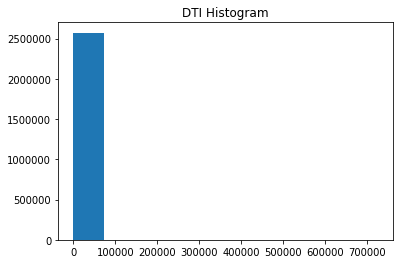

DTI Summary Satistics
mean 102.86531663677926
median 20.71
min -1.0
max 724496.0


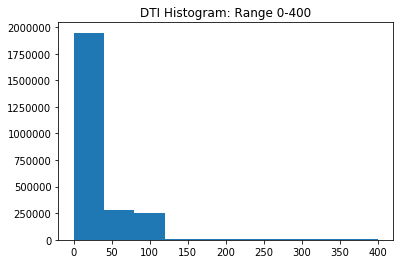

In [13]:
#With DTI, wee see a small amount of NA's, 
loan_data.dti = loan_data.dti.astype(float)

plt.hist(loan_data.dti.dropna())
plt.title('DTI Histogram')
plt.show()
# This histogram is pretty uninformative

# We can then look at the summary statistics
print("DTI Summary Satistics")
print("mean", np.mean(loan_data.dti.dropna()))
print("median", np.median(loan_data.dti.dropna()))
print("min", np.min(loan_data.dti.dropna()))
print("max", np.max(loan_data.dti.dropna()))

plt.hist(loan_data.dti.dropna(), bins=10, range=(0, 400))
plt.title("DTI Histogram: Range 0-400")
plt.show()

# We can see a clear skew to the right, with the mean much larger than
# the median. The max as well indicates that there are extreme outliers

In [14]:
# We'll replace the N/A's with median, (as opposed to the mean)
# as its robust to outliers
loan_data.dti.fillna(np.median(loan_data.dti.dropna()), inplace=True)



In [15]:
# We also need to deal with the -1 scores

# All people who had -1 on their thing also had less than 1 year of work, 
# so, I'm assuming the -1 comes from not being able to compute the DTI
# due to zero income

print (np.unique(
    loan_data.where(loan_data.dti <0).dropna(how = "all").emp_length))

[0.5]


In [16]:
# Explore for NAs
for column in loan_data.columns:
    blanks = loan_data[column].isnull().sum()
    print("{}: {}, {}%".format(column, blanks, 100*np.round(blanks/float(len(loan_data)), 6)))

loan_amnt: 0, 0.0%
title: 0, 0.0%
dti: 0, 0.0%
zip_code: 0, 0.0%
addr_state: 0, 0.0%
emp_length: 0, 0.0%
approved: 0, 0.0%


In [17]:
# Zip codes
len(np.unique(loan_data.zip_code))

976

In [18]:
# We're going to drop this, as the only way to use this would be 
# as a categorical variable with onehot encoding.
# This however would create 976 additional dimensions, almost all of
# of which would be 0. Secondly, it has lots of overlap with the State,
# which we are keeping

loan_data = loan_data.drop('zip_code', axis = 1)

In [19]:
# Change the title and addr_state to categorical
names = ['title', 'addr_state']
for name in names:
    loan_data[name] = loan_data[name].astype('category')
    
loan_data.dtypes

loan_amnt      float64
title         category
dti            float64
addr_state    category
emp_length     float64
approved          bool
dtype: object

### 4. Scaling 

The next thing that I needed to do was scale the data and get it ready for use in scikit. We want our data to be approximatley normally distributed, or at least as close as we can do it. This is important as the assumption of normality is underlying the model process,and give credibility to the metrics that we use.

I created histograms for loan_amnt, dti, and emp_length. All of them were skewed to the right, which can be seen from the histograms and the mean and median. To fix this, I first logged all of the features, which turns exponential relationships into linear linear relationships. I then used Robust Scaler to scale the data. Robust Scaler uses the median and interquartile range to scale, making it more Robust to outliers (which we have). The scaled histograms are also plotted. Both the loan_amnt and dti are approximately normal, which can be seen by the closeness of the mean and the median (as well as the histograms). The emp_lenght was still skewed to the right, though not as much as before. This feature would bhe a candidate for future work, as I could try more ways to scale the feature to be normal.

The categorical data needed to be encoded. I first converted it to integers, and then used OneHot Encoding to create *n* features for each of the *n* integers (for example, with the states, there were 51 dummy variables for the 50 states + Washington D.C.)


loan_amnt
Mean: 12530.320166479254
Median: 10000.0
Max: 300000.0



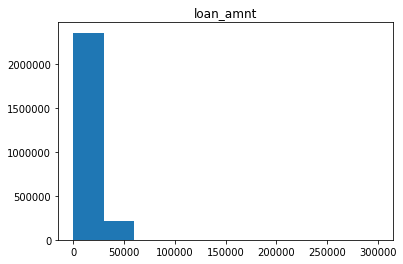

dti
Mean: 102.85490653008671
Median: 20.71
Max: 724496.0



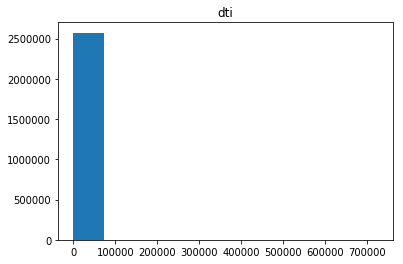

emp_length
Mean: 1.0110863732352076
Median: 0.5
Max: 10.0



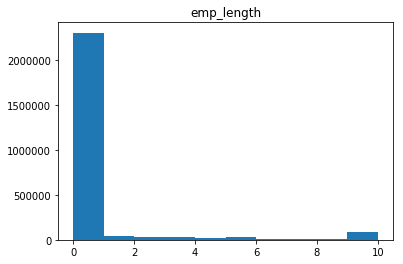

In [20]:
for feature in ['loan_amnt','dti','emp_length']:
    plt.hist(loan_data[feature])
    print(feature)
    print("Mean: {}".format(np.mean(loan_data[feature])))
    print("Median: {}".format(np.median(loan_data[feature])))
    print("Max: {}".format(np.max(loan_data[feature])))
    print()
    plt.title(feature)
    plt.show()
    

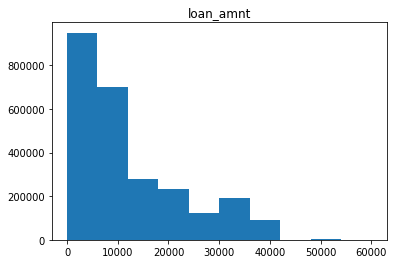

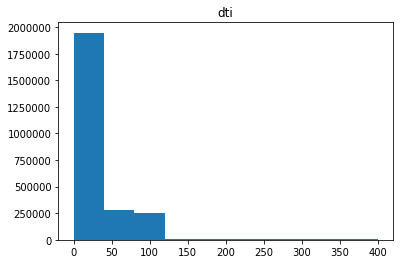

In [21]:
# Make scale adjustments to see the plots without outliers
# for loan_amnt and dti

for feature,rang in [('loan_amnt',60000),('dti',400)]:
    plt.hist(loan_data[feature], range=(0,rang))
    plt.title(feature)
    plt.show()

In [22]:
# Scikit learn needs to convert categories to integers
for feature in ['title', 'addr_state']:
    loan_data[feature] = loan_data[feature].cat.codes
    

# Scale the numercial values, we'll log each of them to try
# and get an approximately normal dist so we can be justified in
# using our evaluation metrics

# We use log1p beause it won't cause an error with 0 values 
# and lets us deal with the -1 dti values
loan_data.loan_amnt = loan_data.loan_amnt.apply(np.log1p)
loan_data.emp_length = loan_data.emp_length.apply(np.log1p)
loan_data.dti = loan_data.dti.apply(np.log1p)

# From log1p, the -1 values become log(-1+1)=log(0)= -inf
# Remember that all of these data points had <1 year of work
# and so we are assuming that the -1 on the dti came from having 
# no income (dividing by 0 would give inf)

# We want them to thus be the worst in the dti, and so we'll replace 
# all -inf with the max

loan_data.dti = loan_data.dti.replace(-np.inf, max(loan_data.dti)+1)

In [23]:
loan_data.dtypes
# our data types are ready for processing

loan_amnt     float64
title            int8
dti           float64
addr_state       int8
emp_length    float64
approved         bool
dtype: object

In [24]:
encode_data = DataFrameMapper([
        (['emp_length'], [preprocessing.RobustScaler()]),
        (['title'], [preprocessing.OneHotEncoder()]),
        (['addr_state'], [preprocessing.OneHotEncoder()]),
        (['dti'], [preprocessing.RobustScaler()]),
        (['loan_amnt'], [preprocessing.RobustScaler()]),
        ('approved', None),
    ], df_out= True)
    
processed_loan_data = encode_data.fit_transform(loan_data)


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a Lab

In [25]:
processed_loan_data.head()

,emp_length,title_x0_0.0,title_x0_1.0,title_x0_2.0,title_x0_3.0,title_x0_4.0,title_x0_5.0,title_x0_6.0,title_x0_7.0,title_x0_8.0,...,addr_state_x0_44.0,addr_state_x0_45.0,addr_state_x0_46.0,addr_state_x0_47.0,addr_state_x0_48.0,addr_state_x0_49.0,addr_state_x0_50.0,dti,loan_amnt,approved
0,0.980829,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.730427,0.000000,True
1,1.540445,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043063,0.541148,True
2,1.791759,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.197803,0.262685,True
3,0.693147,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041082,-0.174204,True
4,1.992430,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.301326,0.615560,True


loan_amnt
Mean: -0.16819644374521986
Median: 0.0
Max: 2.6554722175892262



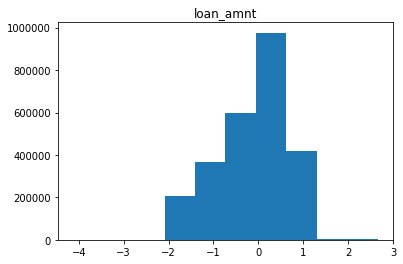

dti
Mean: -0.03492872974442557
Median: 0.0
Max: 8.755973688691702



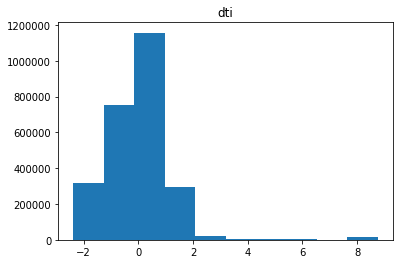

emp_length
Mean: 0.12546046663057442
Median: 0.0
Max: 1.9924301646902063



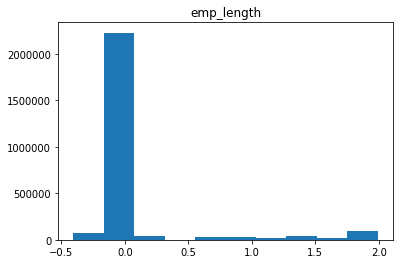

In [26]:
for feature in ['loan_amnt','dti','emp_length']:
    plt.hist(processed_loan_data[feature])
    print(feature)
    print("Mean: {}".format(np.mean(processed_loan_data[feature])))
    print("Median: {}".format(np.median(processed_loan_data[feature])))
    print("Max: {}".format(np.max(processed_loan_data[feature])))
    print()
    plt.title(feature)
    plt.show()

### 5. Modeling

I chose a Random Forest Classifier to be my model. The choice to make this a classification problem was due to the fact that it comes naturally from the set up. We are attempting to tell, given novel data, if a loan request will be rejected or approved. This gives us two classes.

I used a Random Forest for several reasons. Firstly, RF's can handle a large amounts of features from various types (we have both categorical and numnerical, and many of them) and can handle large amount of data (of which we have a lot). Secondly, it has a built in validation technque, called OOB or Out of Bag estimation, which does a good job of estimating the performance on unseen data.

I split the data into a training and test set, stratifying on approved, wth a test set size of 20%. 

I chose the number of estimators to be 100 to be a good compromise between time and size. I also selected the class_weight to be 'balanced_subsample', as this helped to deal with the fact that there were many more rejected than approved data points.

I trained a model using these parameters, and used the OOB score to estimate how well it would do. It got 96.4% accuracy. 

I then used a cross validation technique to choose the max_depth. I had a range of four possible max_depths, and used GridSearchCV to cross validate over all possibilites. It returned a max_depth of 50, which I then used to train a new model. This model's OOB score was 96.6% accuracy, which was an incredibly small improvement, but an improvement nonetheless. 

#### Results

I made classification predictions using the held out data and used the classification report function to report on the results. The overall precision score matched that of the OOB, at 97%. However, there was a dscrepency between the classes. The precision and recall for rejected were 99% and 98%, while the precison and recall for approved was only 65% and 73%. This shows that the classifier is much better at predicting rejected data than approved. The precision of the approved indicates the percentage of data points that were classified as approved were actually approved. Thus, we can see that of the people who were classified as approved, 35% would actually be rejected. The recall tells us how much of those that were actually approved were classified as approved, showing that 27% of those who were actually approved would not be classifed as approved. 

Our model performed a lot better on the rejected data. This could be attributed to aspects of the data, where it is harder to predict approved, or due to the fact that there were so many more rejected data points, which allowed the model to learn more from them and perform much better on the rejected data.

For future work, the next steps would be to try different modeling approaches (instead of tweaking parameters) to see if we could get a model that can predict approved data more accurately. 

In [27]:
# add all features expect approved
feature_cols = [feature for feature in processed_loan_data.columns if feature != 'approved']
features = processed_loan_data.loc[:, feature_cols]

x_train_clf, x_test_clf, y_train_clf, y_test_clf = train_test_split(
    features,
    processed_loan_data.approved,
    test_size=0.2,
    train_size=0.8,
    random_state=10,
    stratify=loan_data.approved)

In [32]:
clf = RandomForestClassifier(n_estimators = 100, oob_score = True,
                            random_state = 10, n_jobs= -1, class_weight = 'balanced_subsample')

In [33]:
clf.fit(x_train_clf, y_train_clf)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=10,
            verbose=0, warm_start=False)

In [34]:
oob = clf.oob_score_
print (oob)

0.9641823300142551


In [28]:
# Optimize the max_depth

param_grid = {'max_depth': [50,100,150,200]}

# Create the model model
clf_opt = RandomForestClassifier(n_estimators = 100, oob_score = True,
                            random_state = 10, n_jobs= -1, class_weight = 'balanced_subsample')

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = clf_opt, param_grid = param_grid, 
                           n_jobs = -1)


In [29]:
grid_search.fit(x_train_clf, y_train_clf)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=10,
            verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [50, 100, 150, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [30]:
best_parameters = grid_search.best_params_

In [31]:
best_parameters

{'max_depth': 50}

In [36]:
clf_opt = RandomForestClassifier(n_estimators = 100, oob_score = True, max_depth = 50,
                            random_state = 10, n_jobs= -1, class_weight = 'balanced_subsample')

In [37]:
clf_opt.fit(x_train_clf, y_train_clf)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=50, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=10,
            verbose=0, warm_start=False)

In [38]:
clf_opt.oob_score_

0.9660135399732388

In [42]:
clf_opt_predict = clf_opt.predict(x_test_clf)

In [48]:
print (classification_report(y_test_clf, clf_opt_predict,
                            target_names = ['rejected', 'approved']))

              precision    recall  f1-score   support

    rejected       0.99      0.98      0.98    488397
    approved       0.65      0.73      0.69     26154

   micro avg       0.97      0.97      0.97    514551
   macro avg       0.82      0.86      0.84    514551
weighted avg       0.97      0.97      0.97    514551



In [47]:
print ("Top 10 features:")
sorted(zip(clf_opt.feature_importances_, 
           list(processed_loan_data)), reverse = True)[:10]

Top 10 features:


[(0.6369479180381388, 'emp_length'),
 (0.18946499404204575, 'dti'),
 (0.09759010960354242, 'loan_amnt'),
 (0.012208718096336734, 'title_x0_10.0'),
 (0.007535546943122782, 'title_x0_1.0'),
 (0.007288179898352476, 'title_x0_6.0'),
 (0.006735708339268878, 'title_x0_2.0'),
 (0.0037705191536503303, 'title_x0_3.0'),
 (0.0031864725327647963, 'title_x0_9.0'),
 (0.002955285839815134, 'title_x0_5.0')]